In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
#import os
#import re
import matplotlib.pyplot as plt
#import pickle
from IPython.display import display, Markdown

#import dbmsbenchmarker
#import bexhoma
from bexhoma import evaluators

%matplotlib inline


In [2]:
cut_at = 0
def plot_measures(metric, smoothing=0, preset_experiment_run=0, preset_client=0):
    display(Markdown(f'# Metric {metric}'))
    list_configurations = list(df_benchmarks['configuration'].unique())    
    for configuration in list_configurations:
        display(Markdown(f'## Configuration {configuration}'))
        list_experiment_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration]['experiment_run'].unique()))
        for experiment_run in list_experiment_runs:
            if preset_experiment_run > 0:
                if preset_experiment_run != experiment_run:
                    continue
            display(Markdown(f'### Experiment run {experiment_run}'))
            list_runs = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['client'].unique()))
            #list_targets = sorted(list(df_benchmarks[df_benchmarks['configuration'] == configuration][df_benchmarks['experiment_run'] == experiment_run]['target'].unique()))
            num_runs = len(list_runs)
            # Create a 2-column grid layout
            n_cols = 2
            if preset_client > 0:
                n_rows = 1
            else:
                n_rows = num_runs
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows), sharex=True)
            # Flatten axes for easy iteration (handles cases with n_rows == 1 or n_cols == 1)
            axes = axes.flatten()
            i = 0
            for client in list_runs:
                if preset_client > 0:
                    if preset_client != client:
                        continue
                #################################
                # show plots with aggregated line
                #################################
                # filter data for this run
                df_part = df_benchmarks[df_benchmarks['configuration'] == configuration]
                df_part = df_part[df_part['experiment_run'] == (experiment_run)]
                df_part = df_part[df_part['client'] == (client)]
                df_total = evaluation.get_benchmark_logs_timeseries_df_aggregated(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                threads = df_part['threads'].sum()
                pod_count = df_part['pod_count'].mean()
                target = df_part['target'].sum()
                # Compute the time spans
                time_spans = df_total.index.to_series().diff().shift(-1).fillna(0)  # Difference between consecutive time indices
                # Weighted average: Multiply each value by its duration and sum
                weighted_sum = (df_total[metric].multiply(time_spans, axis=0)).sum().sum()  # Multiply each value by its time span, sum all values
                total_time = time_spans.sum()  # Total time span
                # Compute the weighted average
                weighted_average = weighted_sum / total_time
                df_total['avg'] = weighted_average
                df_total = df_total.rename(columns={'avg': f'avg={weighted_average}'})
                #df_total = df_total.fillna(0)
                # optionally smoothen graph
                if smoothing > 0:
                    df_total[metric] = df_total[metric].rolling(window=smoothing, min_periods=1).mean()
                # optionally leave out data at the end (cool down)
                if cut_at > 0:
                    df_total = df_total[:-cut_at]
                # generate plot
                title = "{}/{} threads - target = {}".format(threads, int(pod_count), target)
                ax = axes[i]
                i = i + 1
                max_value = df_total[metric].max()
                print(max_value)
                df_total.plot(title=title, ax=ax, ylim=(0,max_value*1.1), use_index=True)
                last_x = df_total.index[-1] # Get the last datapoint's x-coordinate (the last index)
                ax.axvline(x=last_x, color='red', linestyle='--', label='Last Datapoint') # Add a vertical line at the last datapoint
                ###############################
                # show plots with lines per pod
                ###############################
                df_list = evaluation.get_benchmark_logs_timeseries_df_single(metric=metric, configuration=configuration, client=client, experiment_run=experiment_run)
                # collect in one dataframe
                df_total = pd.DataFrame()
                j=1
                max_value = 0
                for df in df_list:
                    # optionally leave out data at the end (cool down)
                    if cut_at > 0:
                        df_tmp = df[metric][:-cut_at]
                    else:
                        df_tmp = df[metric]
                    df_single = pd.DataFrame(df_tmp)
                    if max_value < df_single[metric].max():
                        max_value = df_single[metric].max()
                    df_single.columns=["pod "+str(j)]
                    df_total = pd.merge(df_total, df_single, how='outer', left_index=True, right_index=True)
                    j = j + 1
                #print(df_combined)
                # Compute the time spans
                time_spans = df_total.index.to_series().diff().shift(-1).fillna(0)  # Difference between consecutive time indices
                weighted_sum = (df_total.multiply(time_spans, axis=0)).sum().sum()  # Multiply each value by its time span, sum all values
                total_time = time_spans.sum()  # Total time span
                # Compute the weighted average
                weighted_average = weighted_sum / total_time / len(df_list)
                df_total['avg'] = weighted_average
                df_total = df_total.rename(columns={'avg': f'avg={weighted_average}'})
                #df_total = df_total.fillna(0)
                # optionally smoothen graph
                if smoothing > 0:
                    df_total = df_total.rolling(window=smoothing, min_periods=1).mean()
                # generate plot
                title = "{}/{} threads - target = {}".format(threads, int(pod_count), target)
                ax = axes[i]
                i = i + 1
                df_total.plot(title=title, ax=ax, ylim=(0,max_value*1.1), use_index=True, legend=False)
                last_x = df_total.index[-1] # Get the last datapoint's x-coordinate (the last index)
                ax.axvline(x=last_x, color='red', linestyle='--', label='Last Datapoint') # Add a vertical line at the last datapoint
            # Hide any unused subplots
            for j in range(num_runs*2, len(axes)):
                fig.delaxes(axes[j])
            plt.tight_layout()
            plt.show()

def plot_heatmap(df_aggregated, metric, pod_count, experiment_run):
    #metric = '[OVERALL].Throughput(ops/sec)'
    #pod_count = 1
    #experiment_run = 1
    df_heatmap = df_aggregated[['experiment_run', 'threads', 'target', 'pod_count', metric]]
    df_heatmap = df_heatmap[df_heatmap['pod_count'] == pod_count]
    df_heatmap = df_heatmap[df_heatmap['experiment_run'] == experiment_run]
    #print(df_heatmap)
    df_heatmap = df_heatmap.pivot(index='threads', columns='target', values=metric)
    display(df_heatmap.style.background_gradient(cmap='Blues', axis=None))

In [3]:
code = "1738060417"
#path = "D:\\data\\benchmarks-250126"
path = "/home/perdelt/benchmarks"
evaluation = evaluators.ycsb(code=code, path=path)

In [4]:
df_benchmarks = evaluation.get_df_benchmarking()
#df = df[df.columns.drop(list(df.filter(regex='FAILED')))]
df_benchmarks = evaluation.benchmarking_set_datatypes(df_benchmarks)
df_benchmarks.T

connection_pod,PostgreSQL-64-8-196608-12-1,PostgreSQL-64-8-196608-12-2,PostgreSQL-64-8-196608-2-1,PostgreSQL-64-8-196608-3-1,PostgreSQL-64-8-196608-15-1,PostgreSQL-64-8-196608-7-1,PostgreSQL-64-8-196608-18-1,PostgreSQL-64-8-196608-5-1,PostgreSQL-64-8-196608-3-2,PostgreSQL-64-8-196608-3-3,...,PostgreSQL-64-8-196608-3-16,PostgreSQL-64-8-196608-6-15,PostgreSQL-64-8-196608-2-8,PostgreSQL-64-8-196608-15-15,PostgreSQL-64-8-196608-12-16,PostgreSQL-64-8-196608-15-16,PostgreSQL-64-8-196608-6-16,PostgreSQL-64-8-196608-5-8,PostgreSQL-64-8-196608-8-8,PostgreSQL-64-8-196608-11-8
connection,PostgreSQL-64-8-196608-12,PostgreSQL-64-8-196608-12,PostgreSQL-64-8-196608-2,PostgreSQL-64-8-196608-3,PostgreSQL-64-8-196608-15,PostgreSQL-64-8-196608-7,PostgreSQL-64-8-196608-18,PostgreSQL-64-8-196608-5,PostgreSQL-64-8-196608-3,PostgreSQL-64-8-196608-3,...,PostgreSQL-64-8-196608-3,PostgreSQL-64-8-196608-6,PostgreSQL-64-8-196608-2,PostgreSQL-64-8-196608-15,PostgreSQL-64-8-196608-12,PostgreSQL-64-8-196608-15,PostgreSQL-64-8-196608-6,PostgreSQL-64-8-196608-5,PostgreSQL-64-8-196608-8,PostgreSQL-64-8-196608-11
configuration,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,...,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608,PostgreSQL-64-8-196608
experiment_run,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
client,12,12,2,3,15,7,18,5,3,3,...,3,6,2,15,12,15,6,5,8,11
pod,12d95xt.dbmsbenchmarker,12p7hvg.dbmsbenchmarker,7fqzw.dbmsbenchmarker,vpljc.dbmsbenchmarker,15bx6m9.dbmsbenchmarker,tqh84.dbmsbenchmarker,18t6bll.dbmsbenchmarker,jh4w7.dbmsbenchmarker,bx9fp.dbmsbenchmarker,6sdhm.dbmsbenchmarker,...,vzv7k.dbmsbenchmarker,dhrfh.dbmsbenchmarker,mzvfw.dbmsbenchmarker,157vx4x.dbmsbenchmarker,12vmw9m.dbmsbenchmarker,156hjvs.dbmsbenchmarker,qx929.dbmsbenchmarker,p2tzv.dbmsbenchmarker,76d5r.dbmsbenchmarker,11rfq6b.dbmsbenchmarker
pod_count,16,16,8,16,16,1,16,8,16,16,...,16,16,8,16,16,16,16,8,8,8
threads,7,7,12,6,8,112,8,13,6,6,...,6,6,12,8,7,8,6,13,14,15
target,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sf,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
workload,c,c,c,c,c,c,c,c,c,c,...,c,c,c,c,c,c,c,c,c,c


In [5]:
df_aggregated = evaluation.benchmarking_aggregate_by_parallel_pods(df_benchmarks)

In [6]:
metric = '[OVERALL].Throughput(ops/sec)'
pod_count = 1
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,175123.681100
104,193223.077930
112,186168.143285
120,190270.347407
128,163981.102459
136,161941.629531


In [7]:
metric = '[OVERALL].Throughput(ops/sec)'
pod_count = 8
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,180483.411926
104,176951.656210
112,188020.095816
120,173329.167261
128,181703.626588
136,159902.663013


In [22]:
metric = '[OVERALL].Throughput(ops/sec)'
pod_count = 16
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

ValueError: Index contains duplicate entries, cannot reshape

In [8]:
metric = '[READ].AverageLatency(us)'
pod_count = 1
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,483.575868
104,470.957636
112,511.591911
120,520.580863
128,699.557571
136,693.791023


In [9]:
metric = '[READ].AverageLatency(us)'
pod_count = 8
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,462.500361
104,494.518923
112,540.055148
120,631.829863
128,597.274593
136,721.991125


In [10]:
metric = '[READ].99thPercentileLatency(us)'
pod_count = 1
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,986.000000
104,1077.000000
112,1269.000000
120,1220.000000
128,1444.000000
136,1636.000000


In [11]:
metric = '[READ].99thPercentileLatency(us)'
pod_count = 8
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,1235.375000
104,1302.000000
112,1281.000000
120,1405.875000
128,1457.750000
136,1614.000000


In [12]:
metric = '[READ].MaxLatency(us)'
pod_count = 1
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,13787135.000000
104,88959.000000
112,89151.000000
120,101247.000000
128,106623.000000
136,107199.000000


In [13]:
metric = '[READ].MaxLatency(us)'
pod_count = 8
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,56223.000000
104,52671.000000
112,52351.000000
120,205311.000000
128,53759.000000
136,208767.000000


In [14]:
metric = '[READ].MinLatency(us)'
pod_count = 1
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,157.000000
104,157.000000
112,163.000000
120,166.000000
128,158.000000
136,163.000000


In [15]:
metric = '[READ].MinLatency(us)'
pod_count = 8
experiment_run = 1
plot_heatmap(df_aggregated, metric, pod_count, experiment_run)

target,0
threads,
96,153.000000
104,153.000000
112,156.000000
120,149.000000
128,154.000000
136,153.000000


# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

237172.8


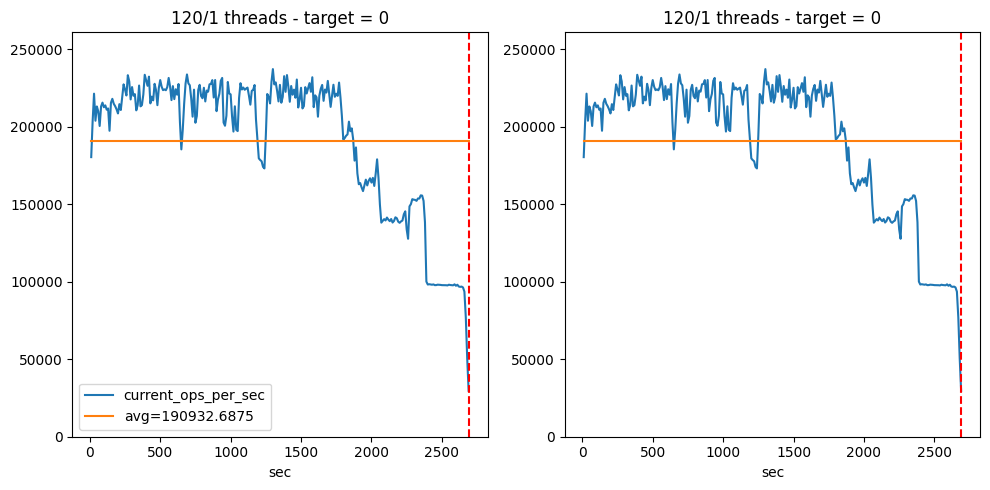

# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

219891.66999999998


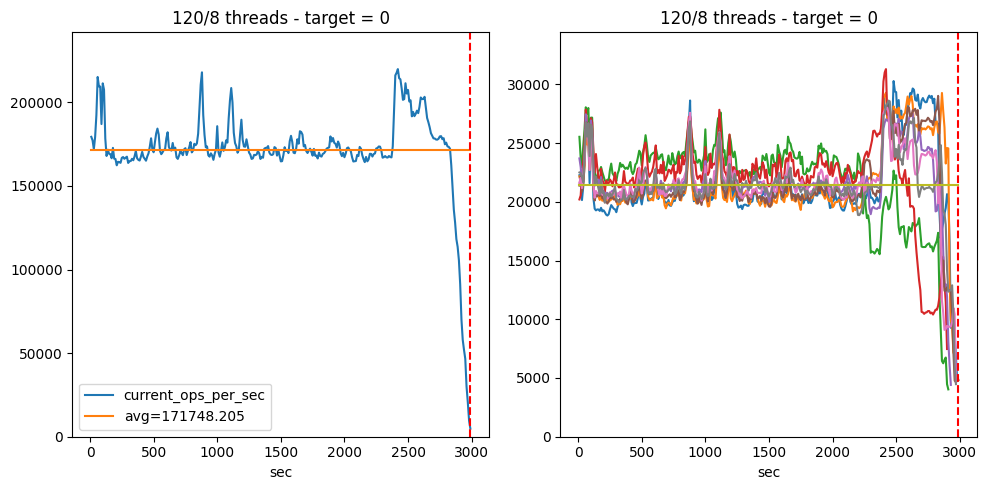

# Metric current_ops_per_sec

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

219190.30000000002


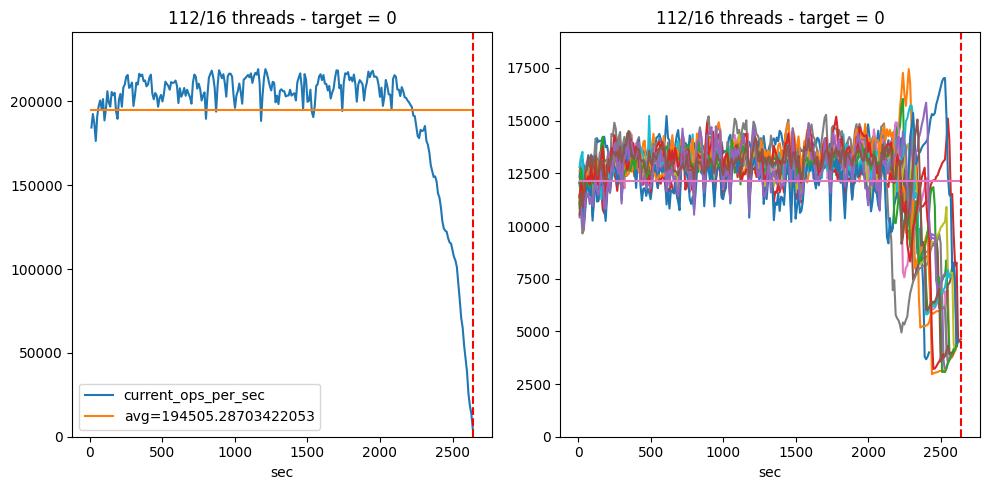

In [26]:
metric = 'current_ops_per_sec'
plot_measures(metric, smoothing=0, preset_client=10)
plot_measures(metric, smoothing=0, preset_client=11)
plot_measures(metric, smoothing=0, preset_client=12)


# Metric READ_Avg

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

690.08


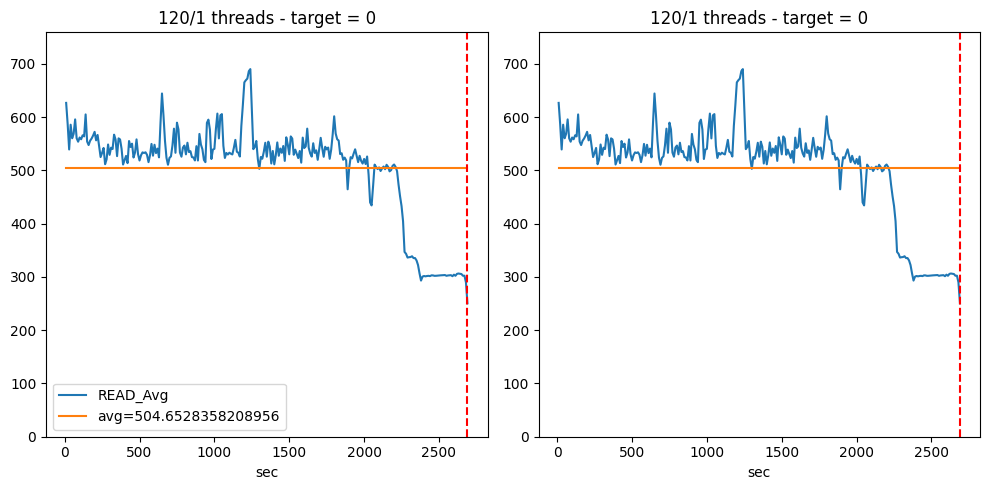

# Metric READ_Avg

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

736.3699999999999


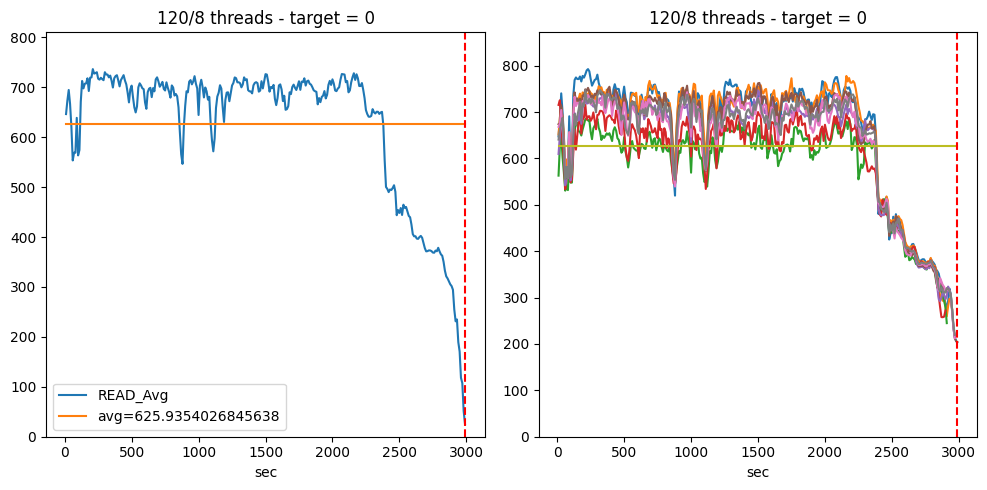

# Metric READ_Avg

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

633.803125


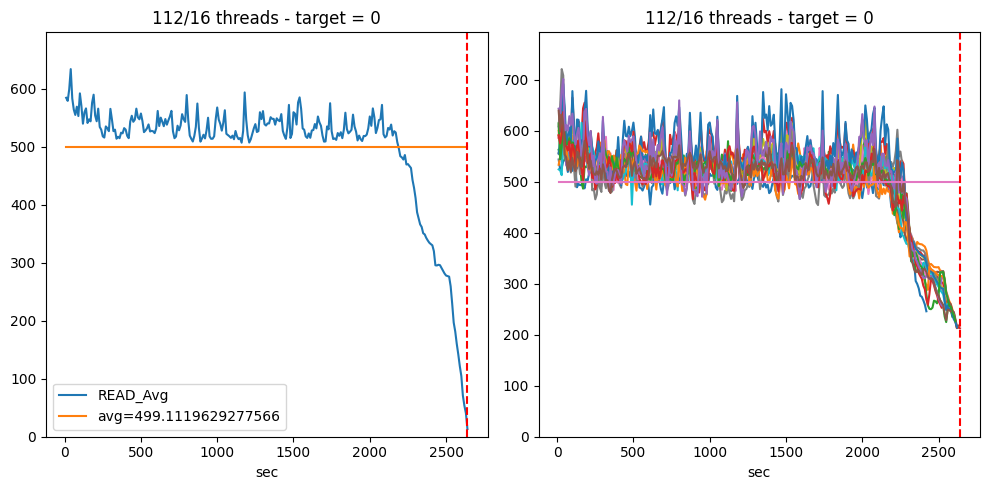

In [29]:
metric = 'READ_Avg'
plot_measures(metric, smoothing=0, preset_client=10)
plot_measures(metric, smoothing=0, preset_client=11)
plot_measures(metric, smoothing=0, preset_client=12)

# Metric READ_99

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

1544


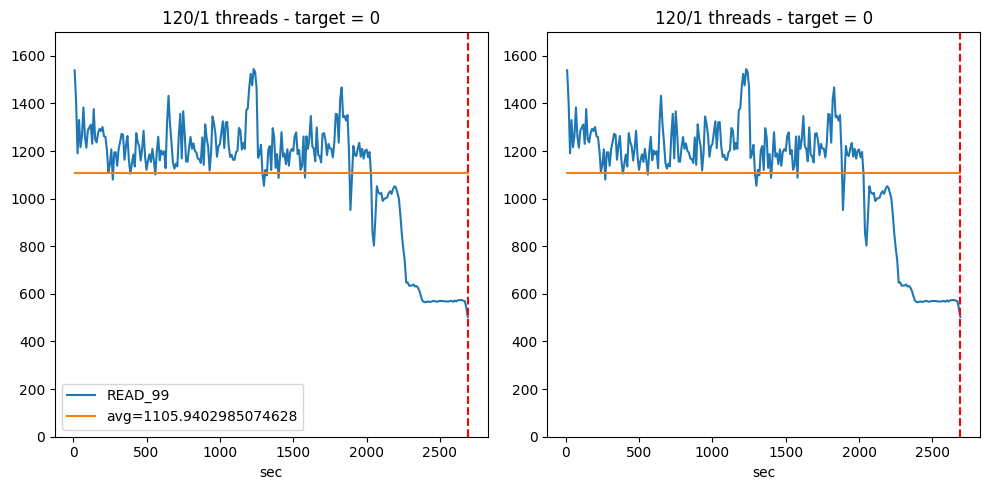

# Metric READ_99

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

2209


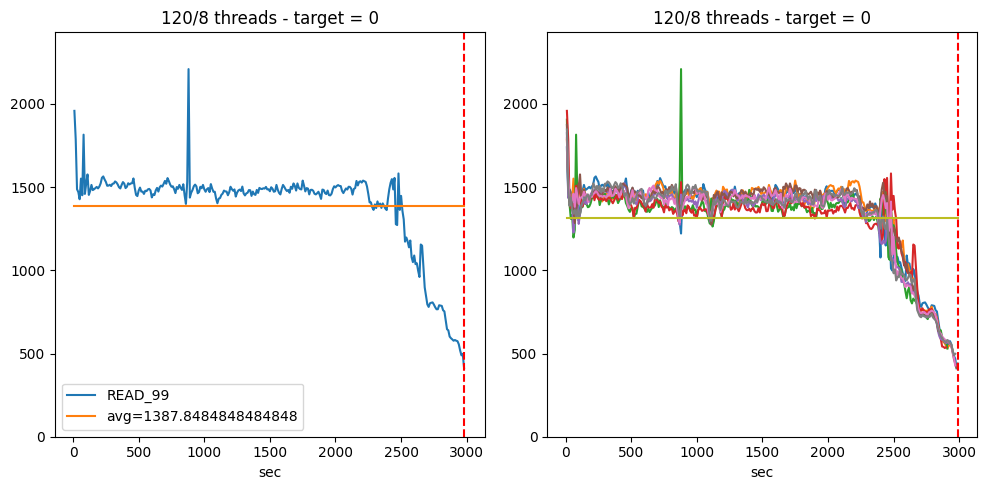

# Metric READ_99

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

2545


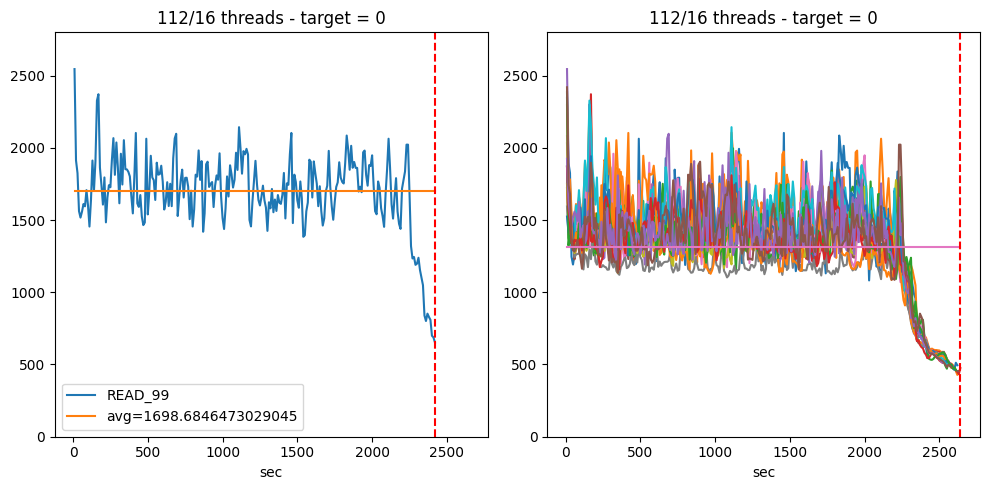

In [28]:
metric = 'READ_99'
plot_measures(metric, smoothing=0, preset_client=10)
plot_measures(metric, smoothing=0, preset_client=11)
plot_measures(metric, smoothing=0, preset_client=12)

# Metric READ_Max

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

101247.0


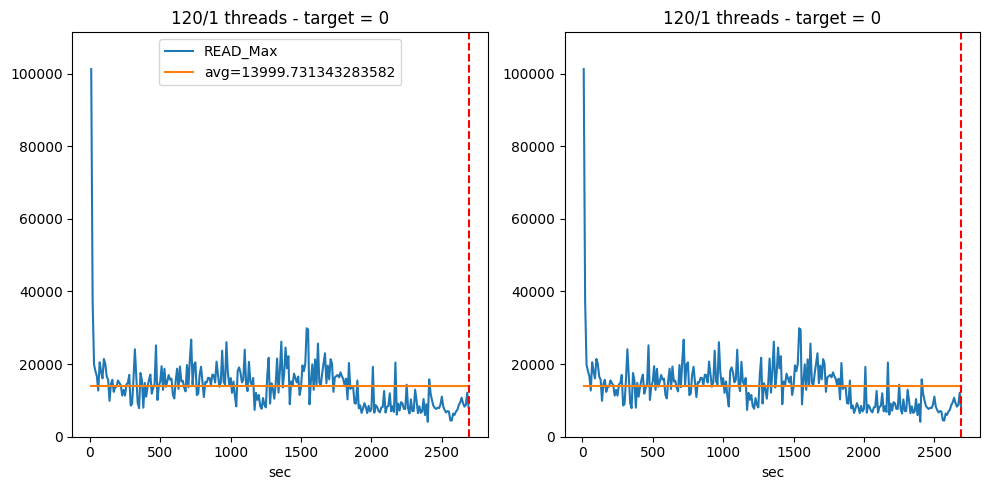

# Metric READ_Max

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

41117.0


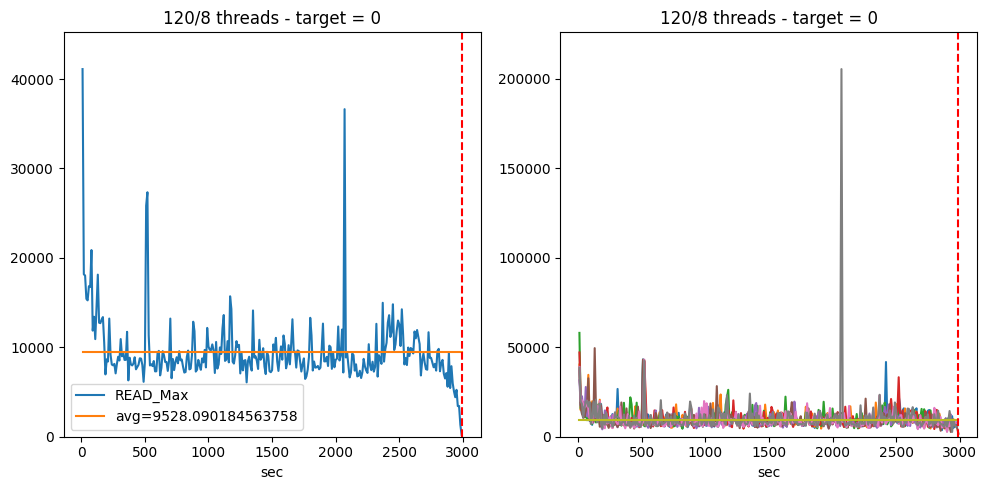

# Metric READ_Max

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

43538.5


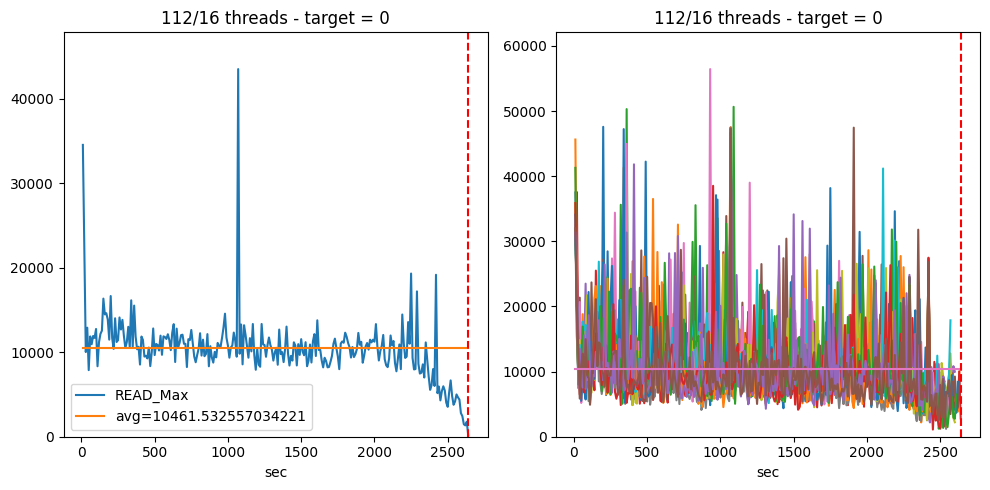

In [27]:
metric = 'READ_Max'
plot_measures(metric, smoothing=0, preset_client=10)
plot_measures(metric, smoothing=0, preset_client=11)
plot_measures(metric, smoothing=0, preset_client=12)

# Metric READ_Min

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

254.8125


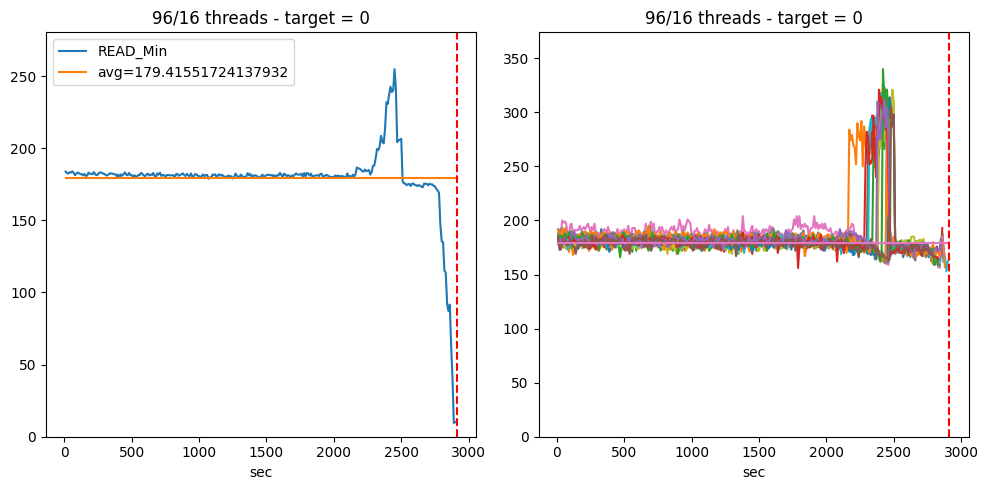

# Metric READ_Min

## Configuration PostgreSQL-64-8-196608

### Experiment run 1

195.0


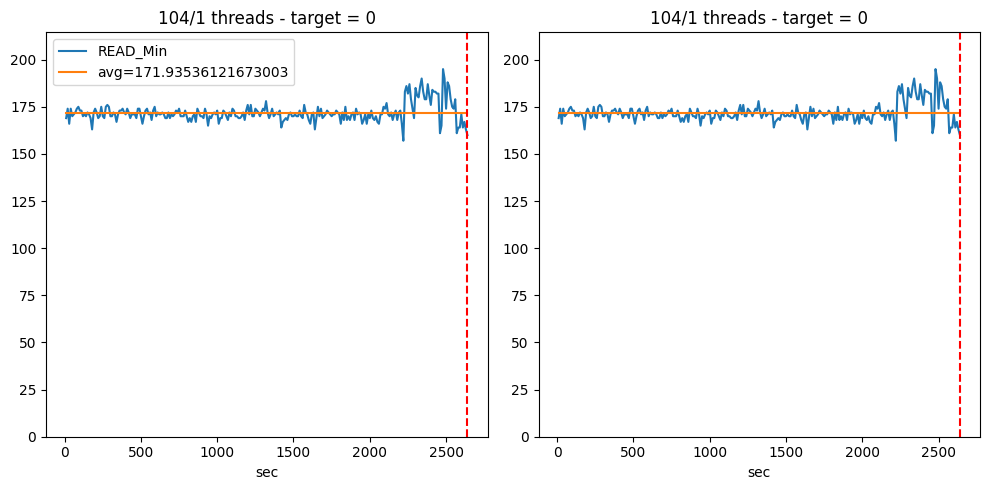

In [20]:
metric = 'READ_Min'
plot_measures(metric, smoothing=0, preset_client=3)
plot_measures(metric, smoothing=0, preset_client=4)

In [21]:
#metric = 'UPDATE_99.9'
#plot_measures(metric, smoothing=0, preset_client=3)
#plot_measures(metric, smoothing=0, preset_client=4)